In [3]:
import torch
from IPython import display
from matplotlib import pyplot as plt 
import numpy as np
import random

## 生成数据集

构造一个简单的训练集，样本数为1000，特征个数为2。 线性回归的真实权重为$w = [2,-3.4]^T$ 偏差$b = 4.2$。随机生成的样本符合均值为0，标准差为1的正态分布，并且为其添加噪声，噪声服从均值为0，标准差为0.01的正态分布。
然后生成第二个特征和标签的散点图，可以更直观的观测两者的线性关系。

tensor([-0.6916,  1.0949]) tensor(-0.9040)


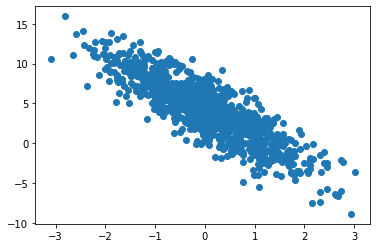

In [20]:
num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2

features = torch.from_numpy(np.random.normal(0,1,(num_examples,num_inputs)))
features = features.float()
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += torch.from_numpy(np.random.normal(0,0.01,size=labels.size()))

print(features[0],labels[0])

plt.scatter(features[:,1].numpy(),labels.numpy())

## 读取数据
训练模型的时候，需要遍历数据集并不断的读取小批量样本数据。 这里定义一个函数，它每次返回`batch_size`（批量大小）个随机样本数据的特征和标签。

In [6]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # 生成样本的index
    random.shuffle(indices) # 洗牌，样本读取顺序是随机的
    for i in range(0,num_examples,batch_size):
        j = torch.LongTensor(indices[i:min(i + batch_size,num_examples)])
        yield features.index_select(0,j),labels.index_select(0,j)

batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,y)
    break

tensor([[ 0.7581, -1.0815],
        [-1.5533,  0.7440],
        [-0.5597,  1.3104],
        [-0.9394, -0.4327],
        [ 0.4416, -0.6013],
        [-0.9756,  0.8492],
        [-0.7422,  0.7570],
        [ 1.4515,  0.2212],
        [ 1.0287, -0.2825],
        [ 2.9517, -2.2948]], dtype=torch.float64) tensor([ 9.3859, -1.4323, -1.3622,  3.7979,  7.1306, -0.6544,  0.1663,  6.3339,
         7.2233, 17.9116], dtype=torch.float64)


## 定义模型

线性回归的模型的较为简单，就是一个矩阵的乘法。可以使用`torch.mm`做矩阵乘法。

In [21]:
def linreg(X,w,b):
    return torch.mm(X,w) + b

## 定义损失函数
使用平方损失来定义线性回归的损失函数。

In [10]:
def squared_loss(y_hat,y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2 # 这里返回的是向量

## 定义优化算法
使用小批量随机梯度下降算法，不断的迭代模型参数来优化损失函数。 这里自动求导模块计算得来的梯度是一个批量的梯度和，将它除以批量的大小来得到平均值。

In [11]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

## 初始化参数
将权重参数初始化为均值为0，标准差为0.01的正态随机数，偏差初始化为0.

In [7]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b = torch.zeros(1,dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)



tensor([0.], requires_grad=True)

## 模型训练
在训练中，通过多次迭代优化模型的参数。在每次迭代中，根据当前读取的小批量数据样本，通过调用反向函数`backward`计算小批量的随机梯度，并调用优化算法`sgd`更新模型的参数。 **在每次更新完参数后，要将参数的梯度清零。**

在一个迭代周期（epoch）中，会完整的遍历一次`data_iter`函数，将数据集中的样本都使用一次。 这里迭代的epoch次数以及学习速率`lr`都是超参数。

In [24]:
lr = 0.03
num_epochs = 3
net = linreg # 模型，也可以称为网络结构
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y).sum()
        l.backward()
        sgd([w,b],lr,batch_size)

        w.grad.data.zero_()
        b.grad.data.zero_()
    
    train_l = loss(net(features,w,b),labels)
    print('epoch %d,loss %f' % (epoch + 1,train_l.mean().item()))

# 输出训练结果以及真实值
print(true_w,w)
print(true_b,b)

epoch 1,loss 0.000046
epoch 2,loss 0.000046
epoch 3,loss 0.000046
[2, -3.4] tensor([[ 1.9999],
        [-3.4002]], requires_grad=True)
4.2 tensor([4.1999], requires_grad=True)


# 总结

线性回归的基本要素

## 模型的定义
定义一个（一组）函数来表示输入和输出的关系，这就是模型（model）。 在线性回归中，假设输入和输出之间的关系市线性的
$$
\hat{y} = x_1\cdot w_1 + x_2 \cdot w_2 + b
$$
上面公式中，$w_1,w_2$是权重参数，$b$是偏差（bias），这就是线性回归模型中的参数。

> 在深度学习中，网络的结构就相当于模型，每一个层相当于一个函数。

## 模型的训练

- 训练数据
- 损失函数
- 优化算法 在深度学习中，最常用的优化算法为小批量梯度下降算法（SGD，mini-batch stochastic gradient descent）。